## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images


In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# %matplotlib inline

In [31]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
def compute_object_points():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    shape = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        if shape == None:
            shape = gray.shape[::-1]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints, shape


## And so on and so forth...

In [32]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
objpoints, imgpoints, shape = compute_object_points()

def calibrate_camera(objpoints, imgpoints, shape):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return mtx, dist


In [33]:
# Apply a distortion correction to raw images.
def cal_undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

mtx, dist = calibrate_camera(objpoints, imgpoints, shape)
images = glob.glob('camera_cal/calibration*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    uimg = cal_undistort(img, mtx, dist)
    fn = fname.split('/')[-1]
    print('undistorted_images/'+fn)
    cv2.imwrite('undistorted_images/'+fn,uimg)
    

undistorted_images/calibration5.jpg
undistorted_images/calibration4.jpg
undistorted_images/calibration6.jpg
undistorted_images/calibration7.jpg
undistorted_images/calibration3.jpg
undistorted_images/calibration2.jpg
undistorted_images/calibration1.jpg
undistorted_images/calibration20.jpg
undistorted_images/calibration19.jpg
undistorted_images/calibration18.jpg
undistorted_images/calibration15.jpg
undistorted_images/calibration14.jpg
undistorted_images/calibration16.jpg
undistorted_images/calibration17.jpg
undistorted_images/calibration13.jpg
undistorted_images/calibration12.jpg
undistorted_images/calibration10.jpg
undistorted_images/calibration11.jpg
undistorted_images/calibration9.jpg
undistorted_images/calibration8.jpg


In [34]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
def compute_thresholded_binary_image(img, sx_thresh=(10, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    return sxbinary*255

images = glob.glob('test_images/*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    uimg = cal_undistort(img, mtx, dist)
    fn = fname.split('/')[-1]
    cv2.imwrite('undistorted_images/'+fn,uimg)
    bimg = compute_thresholded_binary_image(uimg)
    print('thresholded_binary_images/'+fn)
    cv2.imwrite('thresholded_binary_images/'+fn,bimg)

thresholded_binary_images/test6.jpg
thresholded_binary_images/test5.jpg
thresholded_binary_images/test4.jpg
thresholded_binary_images/test1.jpg
thresholded_binary_images/test3.jpg
thresholded_binary_images/test2.jpg
thresholded_binary_images/straight_lines2.jpg
thresholded_binary_images/straight_lines1.jpg


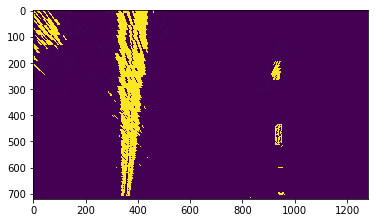

In [35]:
# Apply a perspective transform to rectify binary image ("birds-eye view").
img = mpimg.imread('thresholded_binary_images/straight_lines1.jpg')
src = np.float32([[200, 720],[590, 450],[690, 450], [1110, 720]])
dest = np.float32([[350,720],[350, 0],[950, 0],[950, 720]])

def compute_perspective_transform(img, src, dest):
#     plt.plot(200, 720, 'ro')
#     plt.plot(590, 450, 'ro')
#     plt.plot(690, 450, 'ro')
#     plt.plot(1110, 720, 'ro')
#     plt.imshow(img)
#     plt.show()
    M = cv2.getPerspectiveTransform(src, dest)
    # Warp the image using OpenCV warpPerspective()
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped
warped = compute_perspective_transform(img, src, dest)
cv2.imwrite('transformed_images/straight_lines1.jpg',warped)
plt.imshow(warped)



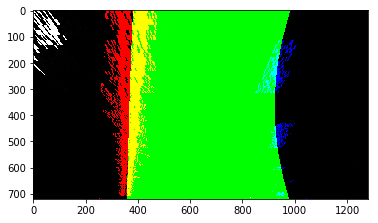

In [36]:
# Detect lane pixels and fit to find the lane boundary.

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    window_img = np.zeros_like(out_img)
    leftlane = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    rightlane = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lanespan = np.hstack((leftlane, rightlane))
    
    cv2.fillPoly(window_img, np.int_([lanespan]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fit, right_fit, result

ploty, left_fitx, right_fitx, out_img = fit_polynomial(warped)
cv2.imwrite('poly_images/straight_lines1.jpg',out_img)
plt.imshow(out_img)

In [37]:
# Determine the curvature of the lane and vehicle position with respect to center.
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)


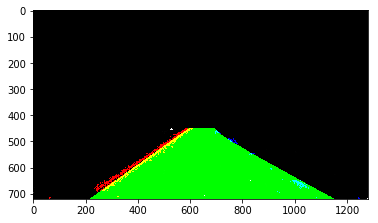

In [38]:
# Warp the detected lane boundaries back onto the original image.
unwarped = compute_perspective_transform(out_img, dest, src)
plt.imshow(unwarped)

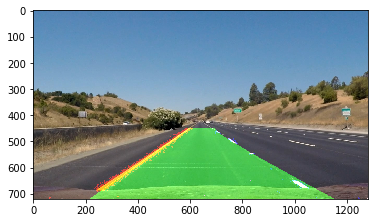

In [39]:
def overlay(original, addon):
    return cv2.addWeighted(original, 1, addon, 0.5, 0)
    
img = mpimg.imread('test_images/straight_lines1.jpg')    
ov = overlay(img, unwarped)
plt.imshow(ov)

overlay_images/straight_lines2.jpg


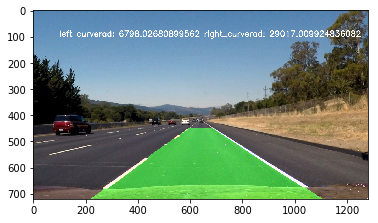

In [40]:
# caliberation
objpoints, imgpoints, shape = compute_object_points()
mtx, dist = calibrate_camera(objpoints, imgpoints, shape)

# pipline on all test images
src = np.float32([[200, 720],[590, 450],[690, 450], [1110, 720]])
dest = np.float32([[350,720],[350, 0],[950, 0],[950, 720]])
images = glob.glob('test_images/straight_lines2.jpg')

def pipline(img):
    uimg = cal_undistort(img, mtx, dist)
    bimg = compute_thresholded_binary_image(uimg)
    warped = compute_perspective_transform(bimg, src, dest)
    ploty, left_fitx, right_fitx, out_img = fit_polynomial(warped)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
    unwarped = compute_perspective_transform(out_img, dest, src)
    ov = overlay(img, unwarped)
    text = 'left curverad: ' + str(left_curverad) + ' right_curverad: ' + str(right_curverad)
    cv2.putText(ov,text,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return ov

for fname in images:
    img = mpimg.imread(fname)
    ov = pipline(img)
    plt.imshow(ov)
    fn = fname.split('/')[-1]
    print('overlay_images/'+fn)
    cv2.imwrite('overlay_images/'+fn, ov)
    



In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return pipline(image)


white_output = 'project_video_lane.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


100%|█████████▉| 1260/1261 [02:20<00:00,  5.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane.mp4 

CPU times: user 1min 57s, sys: 20.7 s, total: 2min 18s
Wall time: 2min 22s


In [ ]:
white_output = 'challenge_video_lane.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)